
#  **DOCUMENTAÇÃO E DESCRIÇÃO DO PROJETO**

# Segmentação de tumores cerebrais - BraTS2020

## Descrição do Dataset BraTS2020
O dataset BraTS (Brain Tumor Segmentation) 2020 é uma coleção de exames de
Ressonância Magnética (MRI) multimodais, utilizada para a segmentação de gliomas.

### Modalidades de Imagem
- **T1**: Imagem T1-ponderada nativa, detalhes anatômicos gerais
- **T1ce**: T1-ponderada com contraste (Gadolinium), realça tumores
- **T2**: T2-ponderada, sensível ao conteúdo de água, identifica edemas
- **FLAIR**: T2 com supressão de líquido cefalorraquidiano

### Rótulos de Segmentação
- **Rótulo 0**: Não tumor (fundo/tecido saudável)
- **Rótulo 1 (NCR/NET)**: Núcleo necrótico e tumor não-realçante
- **Rótulo 2 (ED)**: Edema peritumoral
- **Rótulo 4 (ET)**: Tumor realçante por Gadolínio


## IMPORTS E CONFIGURAÇÕES

In [ ]:
# Deep Learning
import torch
import torch.nn as nn
import torchvision

# Processamento de dados
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Visualização
import matplotlib.pyplot as plt
from matplotlib import pyplot as plot

# Processamento de imagens
import PIL
import cv2 as cv

# Utilitários
import os
import zipfile
import h5py
import random
from collections import defaultdict
import nibabel as nib

# Google Colab
from google.colab import drive

### CONFIGURAÇÃO DE CAMINHOS E MONTAGEM DO DRIVE

In [ ]:
# Google Drive para acessar o dataset
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive
Zip file extracted to: /content/dataset_extracted


In [ ]:
# Configurar caminhos
zip_path = "/content/drive/MyDrive/dataset/data.zip"
extracted_dir = "/content/brats2020_nifti"

print(f"📁 Zip Path: {zip_path}")
print(f"📁 Extracted Dir: {extracted_dir}")

# Verificar se o arquivo existe
if os.path.exists(zip_path):
    print("✅ Arquivo ZIP encontrado")
else:
    print("❌ Arquivo ZIP não encontrado - verifique o caminho")

Zip Path: /content/drive/MyDrive/dataset/data.zip
Extracted Dir: /content/brats2020_nifti


## EXTRAÇÃO E ANÁLISE INICIAL

In [ ]:

def extract_and_analyze_nifti_dataset(zip_path, extract_to):
    """
    Extrai e analisa dataset BraTS2020 em formato NIfTI
    """
    print(f"📦 EXTRAINDO DATASET NIFTI...")

    # Criar diretório se não existir
    os.makedirs(extract_to, exist_ok=True)

    # Extrair ZIP
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            file_list = zip_ref.namelist()
            print(f"   📊 Total de arquivos no ZIP: {len(file_list)}")

            # Extrair
            zip_ref.extractall(extract_to)
            print(f"   ✅ Extração concluída")

    except Exception as e:
        print(f"   ❌ Erro na extração: {e}")
        return None

    # Analisar estrutura extraída
    print(f"\n🔍 ANALISANDO ESTRUTURA EXTRAÍDA...")

    # Procurar arquivos .nii
    nii_files = []
    for root, dirs, files in os.walk(extract_to):
        for file in files:
            if file.endswith(('.nii')):
                nii_files.append(os.path.join(root, file))

    print(f"   📊 Arquivos NIfTI encontrados: {len(nii_files)}")

    # Analisar padrões dos arquivos
    if nii_files:
        # Agrupar por tipo de dados
        training_files = [f for f in nii_files if 'Training' in f or 'training' in f]
        validation_files = [f for f in nii_files if 'Validation' in f or 'validation' in f]

        print(f"   🎯 Arquivos de Training: {len(training_files)}")
        print(f"   🎯 Arquivos de Validation: {len(validation_files)}")

    return extract_to, nii_files

# Executar extração
if os.path.exists(zip_path):
    extracted_path, all_nii_files = extract_and_analyze_nifti_dataset(zip_path, extracted_dir)
else:
    print(f"❌ Arquivo ZIP não encontrado: {zip_path}")
    print("💡 Verifique o caminho do arquivo")

📦 EXTRAINDO DATASET NIFTI...
   📊 Total de arquivos no ZIP: 2349
   ✅ Extração concluída

🔍 ANALISANDO ESTRUTURA EXTRAÍDA...
   📊 Arquivos NIfTI encontrados: 2345
   🎯 Arquivos de Training: 1845
   🎯 Arquivos de Validation: 500

📁 ESTRUTURA DE DIRETÓRIOS:
   📂 BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_080
   📂 BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_112
   📂 BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_141
   📂 BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_228

📋 EXEMPLOS DE ARQUIVOS:
    1. BraTS20_Training_080_seg.nii
    2. BraTS20_Training_080_t1.nii
    3. BraTS20_Training_080_t1ce.nii
    4. BraTS20_Training_080_t2.nii
    5. BraTS20_Training_080_flair.nii
    6. BraTS20_Training_112_seg.nii
    7. BraTS20_Training_112_t2.nii
    8. BraTS20_Training_112_t1.nii
    9. BraTS20_Training_112_flair.nii
   10. BraTS20_Training_112_t1ce.nii


## ORGANIZAÇÃO DOS DADOS POR PACIENTES

In [ ]:
def organize_patients_from_folders(data_dir):
    """Organiza pacientes já estruturados em pastas"""

    patients = {}

    # Procurar pastas de pacientes
    for root, dirs, files in os.walk(data_dir):
        nii_files_in_folder = [f for f in files if f.endswith('.nii')]

        if nii_files_in_folder:
            # Extrair ID do paciente do nome da pasta
            folder_name = os.path.basename(root)
            if 'BraTS20' in folder_name:
                patient_id = folder_name
                patients[patient_id] = {}

                # Organizar modalidades
                for file in nii_files_in_folder:
                    file_path = os.path.join(root, file)

                    if 'flair' in file:
                        patients[patient_id]['flair'] = file_path
                    elif 't1ce' in file:
                        patients[patient_id]['t1ce'] = file_path
                    elif 't1' in file and 't1ce' not in file:
                        patients[patient_id]['t1'] = file_path
                    elif 't2' in file:
                        patients[patient_id]['t2'] = file_path
                    elif 'seg' in file:
                        patients[patient_id]['seg'] = file_path

    print(f"📊 Total de pacientes: {len(patients)}")

    return patients


#Executar a organização
patients_data = organize_patients_from_folders(extracted_path)
all_patients = list(patients_data.keys())
print(f"✅ {len(all_patients)} pacientes organizados")

📊 Total de pacientes: 494
✅ 494 pacientes organizados


## DIVISÃO TREINO/TESTE/VALIDAÇÃO


In [ ]:

def create_splits(complete_patients):
    """
    Criar divisões treino/validação/teste
    """
    print(f"📊 CRIANDO DIVISÕES...")

    # Separar por Training e Validation naturalmente
    training_patients = [p for p in complete_patients if 'Training' in p]
    validation_patients = [p for p in complete_patients if 'Validation' in p]

    print(f"   🎯 Training: {len(training_patients)} pacientes")
    print(f"   🎯 Validation: {len(validation_patients)} pacientes")

    # Se temos validation, usar como teste e dividir training
    if validation_patients:
        random.seed(42)
        random.shuffle(training_patients)

        # 80% treino, 20% validação do conjunto training
        split_idx = int(0.8 * len(training_patients))

        train_set = training_patients[:split_idx]
        val_set = training_patients[split_idx:]
        test_set = validation_patients

    else:
        # Divisão manual
        random.seed(42)
        random.shuffle(complete_patients)

        train_size = int(0.7 * len(complete_patients))
        val_size = int(0.15 * len(complete_patients))

        train_set = complete_patients[:train_size]
        val_set = complete_patients[train_size:train_size + val_size]
        test_set = complete_patients[train_size + val_size:]

    print(f"   📈 FINAL:")
    print(f"     Treino: {len(train_set)}")
    print(f"     Validação: {len(val_set)}")
    print(f"     Teste: {len(test_set)}")

    return train_set, val_set, test_set


train_patients, val_patients, test_patients = create_splits(all_patients)

📊 CRIANDO DIVISÕES...
   🎯 Training: 369 pacientes
   🎯 Validation: 125 pacientes
   📈 DIVISÃO FINAL:
     Treino: 295 pacientes
     Validação: 74 pacientes
     Teste: 125 pacientes


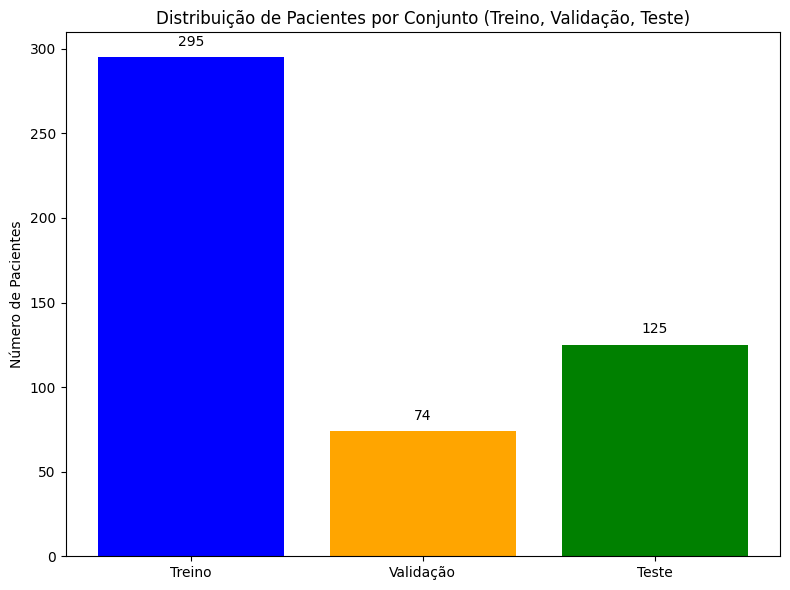

In [ ]:
# Dados para o plot
labels = ['Treino', 'Validação', 'Teste']
counts = [len(train_patients), len(val_patients), len(test_patients)]

# Criar o plot
plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=['blue', 'orange', 'green'])

# Adicionar títulos e rótulos
plt.title('Distribuição de Pacientes por Conjunto (Treino, Validação, Teste)')
plt.ylabel('Número de Pacientes')

# Mostrar os valores em cima das barras
for i, count in enumerate(counts):
    plt.text(i, count + 5, str(count), ha='center', va='bottom') # Adiciona um pequeno offset

# Mostrar o plot
plt.tight_layout()
plt.show()

## Visualização de Exemplo

👤 Exemplo: BraTS20_Training_118
📊 T2 shape: (240, 240, 155)
📊 Segmentação shape: (240, 240, 155)


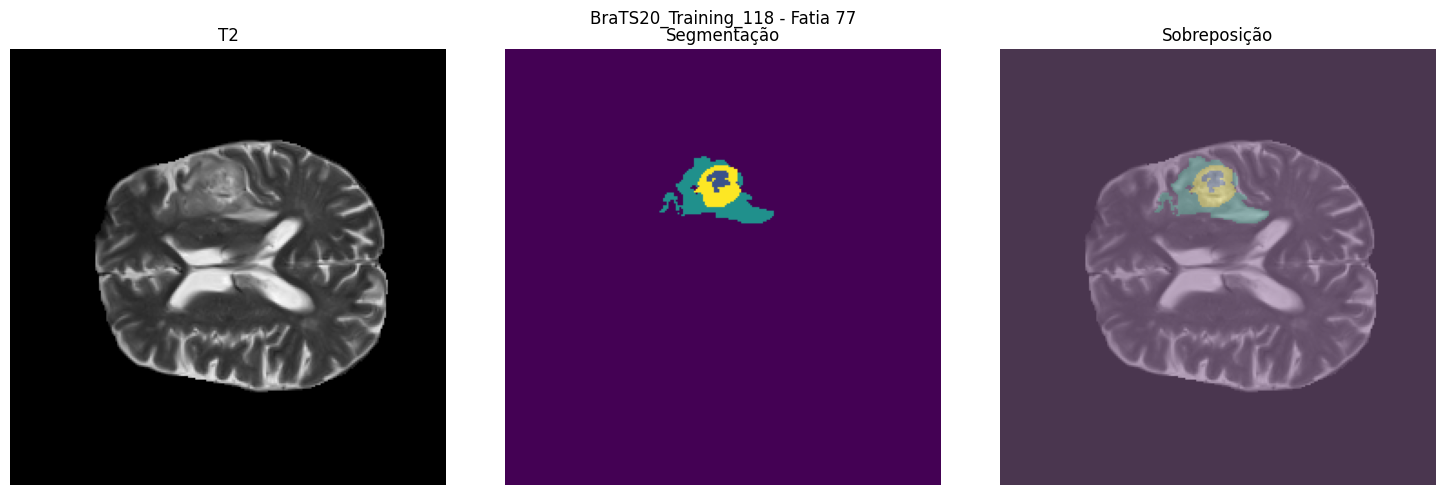

In [ ]:
def load_and_show_example(patient_id, patient_files):
    """
    Carrega e mostra exemplo de um paciente
    """
    print(f"👤 Exemplo: {patient_id}")

    # Carregar T2 e segmentação
    t2_path = patient_files['t2']
    seg_path = patient_files.get('seg', None)

    # Carregar dados NIfTI
    t2_img = nib.load(t2_path)
    t2_data = t2_img.get_fdata()

    print(f"📊 T2 shape: {t2_data.shape}")

    seg_data = None
    if seg_path:
        seg_img = nib.load(seg_path)
        seg_data = seg_img.get_fdata()
        print(f"📊 Segmentação shape: {seg_data.shape}")

    # Visualizar fatia central
    slice_idx = t2_data.shape[2] // 2

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # T2
    axes[0].imshow(t2_data[:, :, slice_idx], cmap='gray')
    axes[0].set_title('T2')
    axes[0].axis('off')

    # Segmentação
    if seg_data is not None:
        axes[1].imshow(seg_data[:, :, slice_idx], cmap='viridis')
        axes[1].set_title('Segmentação')
        axes[1].axis('off')

        # Sobreposição
        axes[2].imshow(t2_data[:, :, slice_idx], cmap='gray', alpha=0.7)
        axes[2].imshow(seg_data[:, :, slice_idx], cmap='viridis', alpha=0.3)
        axes[2].set_title('Sobreposição')
        axes[2].axis('off')

    plt.suptitle(f'{patient_id} - Fatia {slice_idx}')
    plt.tight_layout()
    plt.show()

# Mostrar exemplo do treino
example_patient = train_patients[0]
example_files = patients_data[example_patient]

load_and_show_example(example_patient, example_files)



# U-Net simples

In [ ]:
class Decoder(nn.Module):
    def __init__(self, entry):
        self.deconv = nn.ConvTranspose2d(entry, exit, kernel_size = (2,2))

    def forward(self):
        pass


class ClassicalUnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size = (3,3), stride = 1, padding = 0),
            nn.ReLU(),
            nn.Conv2d(1, 64, kernel_size = (3,3), stride = 1, padding = 0),
            nn.ReLU()
            )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size = (3,3), stride = 1, padding = 0),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size = (3,3), stride = 1, padding = 0),
            nn.ReLU()
            )

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size = (3,3), stride = 1, padding = 0),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size = (3,3), stride = 1, padding = 0),
            nn.ReLU()
            )

        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size = (3,3), stride = 1, padding = 0),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size = (3,3), stride = 1, padding = 0),
            nn.ReLU()
            )

        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size = (3,3), stride = 1, padding = 0),
            nn.ReLU()
            )

        self.deconv1 = nn.Sequential()
        self.deconv2 = nn.Sequential()
        self.deconv3 = nn.Sequential()
        self.deconv4 = nn.Sequential()


        self.maxpool = nn.MaxPool2d(kernel_size= (2,2), stride = 2)
        print("Starting UNet")
        #nn.LazyConv2d

unet = ClassicalUnet()


Starting UNet
